
## **Data Collection**

**Purpose:** Get raw data from sources and save it to disk

**What it does:**
- Downloads/records raw LOB snapshots and trades
- Initial data quality checks (missing values, timestamps, gaps)
- Saves cleaned raw data to `data/interim/` or `data/raw/`
- Basic exploratory data analysis (EDA) to understand the data

In [12]:
# ============================================================================
# 00_data_collection.ipynb
# Purpose: Load and validate raw LOB data
# ============================================================================

# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
from pathlib import Path

# Visualization settings
plt.style.use('seaborn-v0_8-paper')  
plt.rcParams.update({
    'font.family': 'serif',
    'font.weight': 'bold',        
    'axes.labelweight': 'bold',    
    'axes.titleweight': 'bold',   
    'axes.linewidth': 1.2,
    'axes.spines.top': False,
    'axes.spines.right': False,
})
%matplotlib inline


from src.config import RAW_DATA_DIR, INTERIM_DATA_DIR, FIGURES_DIR
from src.data.lob_loader import LOBLoader
from src.utils.data_quality import (
    check_data_quality,
    print_quality_report,
    detect_gaps,
    remove_outliers
)

In [13]:
# %% Configuration
SYMBOL = "BTCUSDT"
INPUT_FILE = "btc_orderbook.parquet"

print(f"Loading data from: {RAW_DATA_DIR / 'binance_snapshots' / INPUT_FILE}")

Loading data from: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/raw/binance_snapshots/btc_orderbook.parquet


In [14]:
# %% Note about data recording
# To record new data, run from terminal:
#   python scripts/download_data.py --symbol BTCUSDT --duration 3600
# 
# This notebook assumes data has already been recorded and saved.


# Download or load raw data
# from scripts.recorders.orderbook_recorder import OrderBookRecorder
# recorder = OrderBookRecorder(symbol="BTCUSDT")
# recorder.record(duration_seconds=3600)

In [15]:
# Load data and inspect data 

print("\n" + "="*60)
print("LOADING DATA")
print("="*60)

loader = LOBLoader()
lob_df = loader.load_files(INPUT_FILE)

print(f"\n Loaded {len(lob_df):,} snapshots")
print(f"Columns: {lob_df.columns.tolist()[:10]}...")


LOADING DATA
LOBLoader initialized with data_dir: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/raw/binance_snapshots
Directory exists: True
Loading 1 LOB snapshot files...
  Resetting timestamp from index to column in btc_orderbook.parquet
Timestamp column preserved and sorted
Loaded 3,600 snapshots with 81 columns

 Loaded 3,600 snapshots
Columns: ['timestamp', 'bid_px_1', 'bid_qty_1', 'bid_px_2', 'bid_qty_2', 'bid_px_3', 'bid_qty_3', 'bid_px_4', 'bid_qty_4', 'bid_px_5']...


/Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/raw/binance_snapshots/btc_orderbook.parquet

In [16]:
# %% Inspect raw data
print("\n" + "="*60)
print("RAW DATA INSPECTION")
print("="*60)

display(lob_df.head())
print(f"\nShape: {lob_df.shape}")
print(f"\nData types:\n{lob_df.dtypes}")


RAW DATA INSPECTION


,timestamp,bid_px_1,bid_qty_1,bid_px_2,bid_qty_2,bid_px_3,bid_qty_3,bid_px_4,bid_qty_4,bid_px_5,...,ask_px_16,ask_qty_16,ask_px_17,ask_qty_17,ask_px_18,ask_qty_18,ask_px_19,ask_qty_19,ask_px_20,ask_qty_20
0,2025-10-09 17:07:08+00:00,119900.47,0.00094,119900.45,0.00229,119890.00,0.00834,119885.26,0.04879,119788.84,...,120595.00,0.24645,120605.85,0.00160,120625.00,0.29963,120632.50,0.00006,120663.16,0.00099
1,2025-10-09 17:07:09+00:00,119900.47,0.00094,119900.45,0.00229,119890.00,0.00834,119885.26,0.04879,119788.82,...,120526.76,0.00010,120536.00,0.12204,120595.00,0.24645,120605.85,0.00160,120625.00,0.29963
2,2025-10-09 17:07:10+00:00,119900.47,0.00094,119900.45,0.00229,119890.00,0.00834,119885.26,0.04879,119788.82,...,120526.76,0.00010,120536.00,0.12204,120595.00,0.24645,120605.85,0.00160,120625.00,0.29963
3,2025-10-09 17:07:11+00:00,119900.47,0.00094,119900.45,0.00229,119890.00,0.00834,119885.27,1.35252,119885.26,...,120526.76,0.00010,120536.00,0.12204,120595.00,0.24645,120605.85,0.00160,120625.00,0.29963
4,2025-10-09 17:07:12+00:00,119900.48,0.04878,119900.47,0.00094,119900.45,0.00229,119890.01,1.35252,119890.00,...,120605.85,0.00160,120632.50,0.00006,120663.16,0.00099,120672.83,0.01021,120735.87,0.00004



Shape: (3600, 81)

Data types:
timestamp     datetime64[ns, UTC]
bid_px_1                  float64
bid_qty_1                 float64
bid_px_2                  float64
bid_qty_2                 float64
                     ...         
ask_qty_18                float64
ask_px_19                 float64
ask_qty_19                float64
ask_px_20                 float64
ask_qty_20                float64
Length: 81, dtype: object


In [17]:
# Data quality checks
print("\n" + "="*60)
print("DATA QUALITY ANALYSIS")
print("="*60)

quality_report = check_data_quality(lob_df, timestamp_col='timestamp')
print_quality_report(quality_report)


DATA QUALITY ANALYSIS
DATA QUALITY REPORT

📊 Basic Info:
  Rows: 3,600
  Columns: 81
  Duplicates: 0

❓ Missing Values:
  bid_px_16: 1 (0.03%)
  bid_qty_16: 1 (0.03%)
  bid_px_17: 3 (0.08%)
  bid_qty_17: 3 (0.08%)
  bid_px_18: 12 (0.33%)
  bid_qty_18: 12 (0.33%)
  bid_px_19: 59 (1.64%)
  bid_qty_19: 59 (1.64%)
  bid_px_20: 371 (10.31%)
  bid_qty_20: 371 (10.31%)
  ask_px_18: 3 (0.08%)
  ask_qty_18: 3 (0.08%)
  ask_px_19: 21 (0.58%)
  ask_qty_19: 21 (0.58%)
  ask_px_20: 114 (3.17%)
  ask_qty_20: 114 (3.17%)

🕐 Timestamp Info:
  Start: 2025-10-09 17:07:08+00:00
  End: 2025-10-09 18:07:07+00:00
  Duration: 1.00 hours
  Median gap: 1.00s
  Max gap: 1.00s



In [18]:
# Check for time gaps
print("\n" + "="*60)
print("TIME GAP ANALYSIS")
print("="*60)

gaps = detect_gaps(lob_df, timestamp_col='timestamp', max_gap_seconds=10.0)
if len(gaps) > 0:
    print(f"\n Found {len(gaps)} gaps:")
    display(gaps)
else:
    print("\n No significant time gaps found")


TIME GAP ANALYSIS
No gaps > 10.0s found

 No significant time gaps found



VISUALIZATIONS


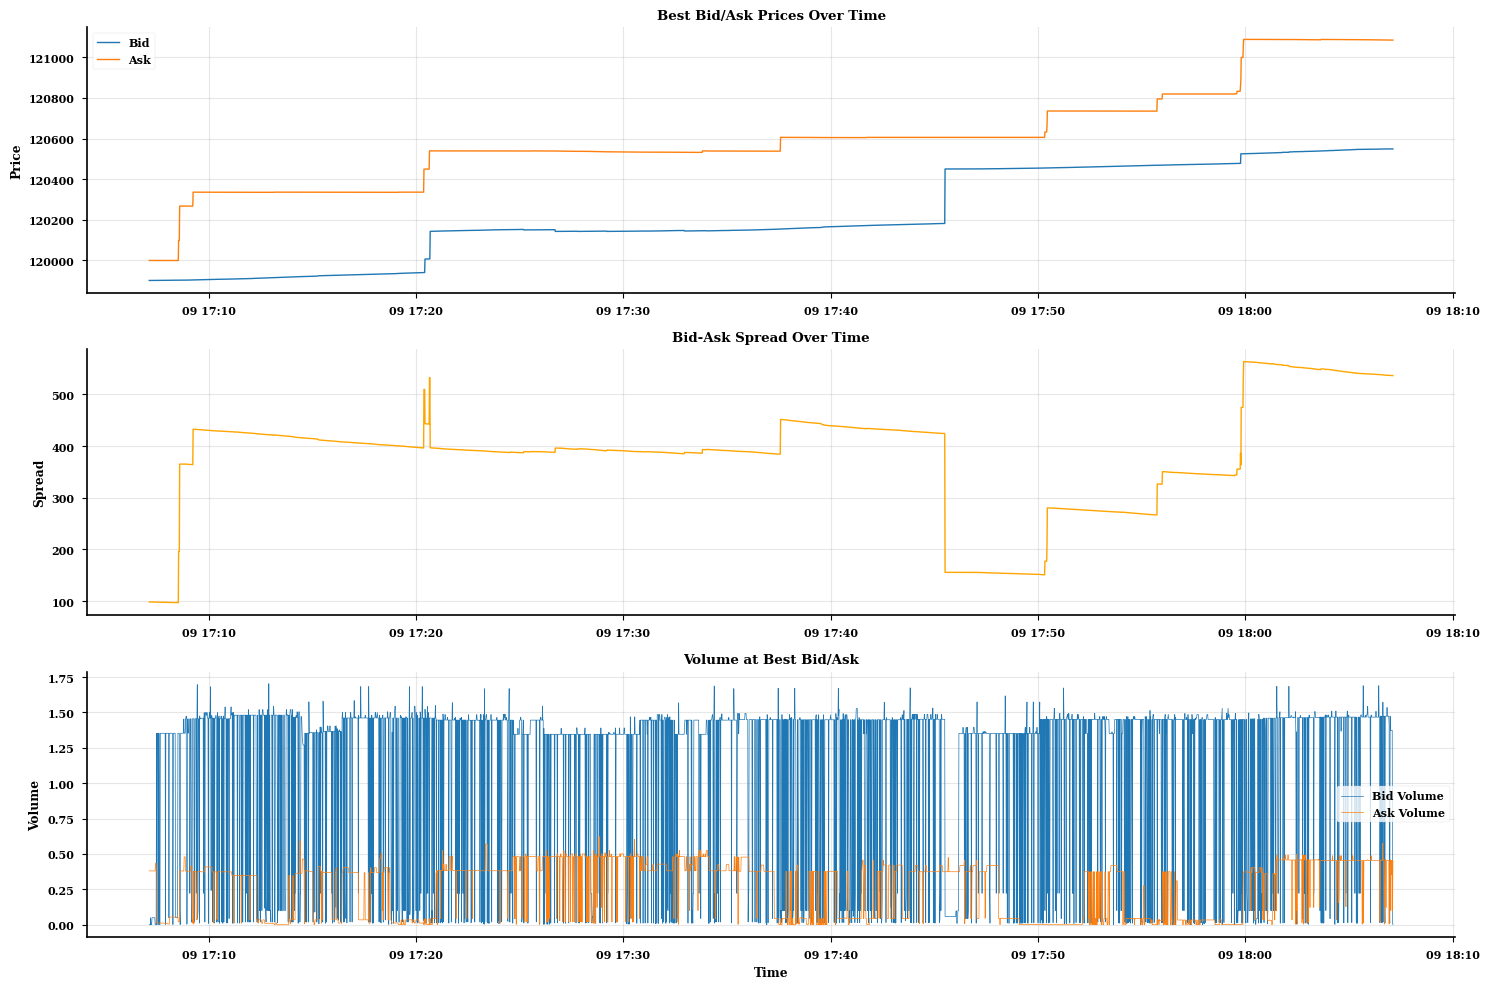

In [19]:
# %% Visualize raw data
print("\n" + "="*60)
print("VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(3, 1, figsize=(15, 10))

# Best bid/ask prices
axes[0].plot(lob_df['timestamp'], lob_df['bid_px_1'], label='Bid', linewidth=1.0)
axes[0].plot(lob_df['timestamp'], lob_df['ask_px_1'], label='Ask', linewidth=1.0)
axes[0].set_title('Best Bid/Ask Prices Over Time')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Spread
spread = lob_df['ask_px_1'] - lob_df['bid_px_1']
axes[1].plot(lob_df['timestamp'], spread, linewidth=1.0, color='orange')
axes[1].set_title('Bid-Ask Spread Over Time')
axes[1].set_ylabel('Spread')
axes[1].grid(True, alpha=0.3)

# Volume at best bid/ask
axes[2].plot(lob_df['timestamp'], lob_df['bid_qty_1'], label='Bid Volume', linewidth=0.5)
axes[2].plot(lob_df['timestamp'], lob_df['ask_qty_1'], label='Ask Volume', linewidth=0.5)
axes[2].set_title('Volume at Best Bid/Ask')
axes[2].set_ylabel('Volume')
axes[2].set_xlabel('Time')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'raw_data_overview.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
# %% Handle missing values and outliers
print("\n" + "="*60)
print("DATA CLEANING")
print("="*60)

print(f"Before cleaning: {len(lob_df):,} rows")

# Drop missing values
lob_df = lob_df.dropna()
print(f"After dropping NaN: {len(lob_df):,} rows")


# Remove outliers (optional - be conservative)
price_cols = ['bid_px_1', 'ask_px_1']
lob_df = remove_outliers(
    lob_df,
    columns=price_cols,
    method='iqr',
    threshold=3.0,
    verbose=True
)

print(f"After outlier removal: {len(lob_df):,} rows")


DATA CLEANING
Before cleaning: 3,600 rows
After dropping NaN: 3,154 rows

Total rows removed: 0 (0.00%)
Remaining rows: 3154
After outlier removal: 3,154 rows


In [21]:
# Save cleaned data
print("\n" + "="*60)
print("SAVING CLEANED DATA")
print("="*60)

INTERIM_DATA_DIR.mkdir(parents=True, exist_ok=True)
output_file = INTERIM_DATA_DIR / f"{SYMBOL}_lob_cleaned.parquet"

lob_df.to_parquet(output_file, index=False)
print(f" Saved cleaned data to: {output_file}")
print(f"File size: {output_file.stat().st_size / 1024 / 1024:.2f} MB")

# %% Summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f" Loaded {len(lob_df):,} clean snapshots")
print(f" Time range: {lob_df['timestamp'].min()} to {lob_df['timestamp'].max()}")
print(f" Saved to: {output_file}")
print(f"\n Next step: Run 10_basic_features.ipynb")


SAVING CLEANED DATA
 Saved cleaned data to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/interim/BTCUSDT_lob_cleaned.parquet
File size: 0.40 MB

SUMMARY
 Loaded 3,154 clean snapshots
 Time range: 2025-10-09 17:07:08+00:00 to 2025-10-09 18:07:07+00:00
 Saved to: /Users/rylanspence/Desktop/Git/HF/Order-Book-Microstructure-Analysis/data/interim/BTCUSDT_lob_cleaned.parquet

 Next step: Run 10_basic_features.ipynb
